# Sample Efficient Reinforcement Learning - from DQN to (almost) Rainbow

In this scenario we will expand upon on the Deep Q-Network (DQN) algorithm [(Mnih 2014)](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf). DQN has been successfully applied to a wide range of environments and has demonstrated strong performance on many tasks. However, several challenges and limitations to the DQN that have been identified in the literature:

1. Sample complexity - DQN can require a large number of samples to learn effectively, especially in environments with high-dimensional state spaces or a large number of possible actions
2. Convergence - DQN is known to converge to the optimal solution under certain conditions, but the convergence properties of the algorithm are not well understood and it is not guaranteed to converge in all cases
3. Overestimation - DQN is known to sometimes overestimate the Q-values of certain actions, which can lead to suboptimal behavior
4. Sensitivity to hyperparameters - DQN can be sensitive to the choice of hyperparameters, such as the learning rate, the discount factor, and the exploration scheme.

Rainbow algorithm [(Hessel 2017)](https://arxiv.org/pdf/1710.02298.pdf) is a combination of several techniques for improving the performance of the DQN algorithm, which was originally proposed by DeepMind. By combining several techniques, the Rainbow algorithm is able to improve the sample efficiency, stability and  performance of the DQN algorithm. Overall, the Rainbow algorithm represents an important step forward in the development of reinforcement learning algorithms and is often used as a baseline for implementing more complex changes to the RL setup (e.g. [(Schwarzer 2021)](https://arxiv.org/pdf/2007.05929.pdf) or [(Srinivas 2020)](https://arxiv.org/pdf/2004.04136.pdf))

In this scenario, you will learn to augment a simple DQN implementation with some of the components of Rainbow. To test our implementations, we will use the Lunar Lander environment. Given resources, the environment is easily solved by a vanilla DQN implementation. But we do not have resources. What we have is a budget of:

1. 40 000 environment steps
2. 35 000 Q-network updates

And quite inefficient exploration scheme. As such, our basic DQN implementation will not be enough to solve Lunar Landing problem within the constraints.

## Homework scenario and grading

We provide you with a basic implementation of the DQN. Your job is to expand it with the following modules:

1. Double Q-Learning - [(van Hasselt 2015)](https://arxiv.org/pdf/1509.06461.pdf)
2. N-step learning - [(Sutton 1988)](http://incompleteideas.net/papers/sutton-88-with-erratum.pdf)
3. Dueling network architecture - [(Wang et al. 2015)](https://arxiv.org/pdf/1511.06581.pdf)
4. (Almost) Rainbow - [(Hessel 2017)](https://arxiv.org/pdf/1710.02298.pdf)

Each module is designed to work independently (i.e. you can implement each individually with DQN). The final task of this scenario is to combine all the implemented modules into (almost) Rainbow agent. Don't forget to visualize your results.

We import the necessary modules:

In [ ]:
!pip install swing
!pip install box2d
!pip install gymnasium[box2d]

  Preparing metadata (setup.py) ... done
  Created wheel for swing: filename=swing-0.0.4-py3-none-any.whl size=3240 sha256=62a712f15370f6fab16b387ec66343fa8b861afe368d36f16392e3b9536c47d6
  Stored in directory: /root/.cache/pip/wheels/32/62/99/7f2bbbf16199481ca1f828144c44068d3b0300c6ba89844052
Successfully built swing
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 45.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
ERROR: ERROR: Failed to build installable wheels for some pypro

In [ ]:
import os
import math
import random
import time

import gymnasium as gym
from google.colab import files
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


We define a simple class for holding the hyperparameters (do not change those!)

In [ ]:
# do not change!
class parse_args:
    def __init__(self):
        self.gym_id = "LunarLander-v3"
        self.capacity = 10000
        self.init_steps = 10000
        self.batch_size = 128
        self.hidden_dim = 128
        self.learning_rate = 7e-4
        self.discount = 0.99
        self.samples = 3
        self.total_timesteps = 40000
        self.target_update_freq = 50
        self.evaluate_freq = 1000
        self.evaluate_samples = 5
        self.anneal_steps = 30000
        self.epsilon_initial = 1
        self.epsilon_limit = 0.01
        self.cuda = True
        env = gym.make(self.gym_id)
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n
        self.device = torch.device("cuda" if torch.cuda.is_available() and self.cuda else "cpu")
        self.layer_class = nn.Linear

args = parse_args()

And two helper functions: one for setting seeds, one for simple orthogonal initialization of linear layers, and one for saving and downloading training results.

In [ ]:
def set_seed_everywhere(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

def weight_init(model):
    if isinstance(model, nn.Linear):
        nn.init.orthogonal_(model.weight.data)
        model.bias.data.fill_(0.0)

def download_numpy(filename, data):
    np.save(filename, data)
    files.download(filename)

## 0. DQN

Deep Q-Network (DQN) [(Mnih 2014)](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) is a reinforcement learning algorithm that uses a deep neural network to learn a Q-function, which is a function that estimates the expected return for taking a given action in a given state. The goal of the DQN algorithm is to learn a policy that maximizes the expected return by learning the Q-function and selecting the action with the highest estimated return in each state.

The DQN algorithm consists of two main components: a Q-network and an experience buffer. The Q-network is a deep neural network that takes in a state as input and outputs the estimated Q-values for each possible action. The experience buffer is a data structure that stores a set of experiences. The DQN algorithm works by interacting with the environment and storing the experiences in the experience buffer. The Q-network is then trained using a mini-batch of experiences uniformly sampled from the experience buffer. This process is known as experience replay and is used to decorrelate the experiences and to stabilize the learning process. The Q-network is updated using the loss function:

$$
\mathcal{L}_{\theta} = \frac{1}{B} \sum_{i=1}^{B} \bigl( \mathrm{TD}~(s_i, a_i, s^{'}_{i}) \bigr)^{2}
$$

With:

$$
\mathrm{TD}~(s_i, a_i, s^{'}_{i}) = Q_{\theta}~(s_i,a_i) - \bigl(r_{(s_i,a_i,s_{i}^{'})} + \gamma ~ \underset{a^{'}_{i} \sim \bar{Q}_{\theta}}{\mathrm{max}} ~ \bar{Q}_{\theta}~(s_{i}^{'},a_{i}^{'}) \bigr)
$$

Where $Q_{\theta}$ and $\bar{Q}_{\theta}$ denote learned and target Q-networks respectively. The target network is a copy of the Q-network that is updated less frequently, and using it to compute the target Q-values helps to stabilize the learning process and improve the performance of the DQN algorithm. Note that to increase stability of training we use Huber loss (smooth_l1_loss) instead of L2.

There are several ways to incorporate exploration into the DQN algorithm. One common method is to use an $\epsilon$-greedy exploration strategy, where the agent takes a random action with probability $\epsilon$ and takes the action with the highest estimated Q-value with probability $1 - \epsilon$. The value of $\epsilon$ is typically decreased over time, so that the agent initially explores more and then gradually shifts towards exploitation as it learns more about the environment.

Below, we implement all the components of a basic DQN. We start with the experience buffer - a data structure that stores a set of transitions, where a transition is typically represented as a tuple $(s, a, r, s', t)$, where $s$ is the state, $a$ is the action taken in state $s$, $r$ is the reward received by performing $a$ in $s$ and getting to $s'$, $s'$ is the new state observed after performing $a$ in $s$ and $t$ is the termination boolean (true if $s'$ is terminal). Experience buffers are used to store the experiences of an agent as it interacts with an environment, and are used to train a Q-function, which is a function that estimates the expected return for taking a given action in a given state. We implement **ExperienceBuffer** class using NumPy arrays and we define two methods:

1. *add* - adds transition to the buffer
2. *sample* - samples a batch of transitions from the buffer

In [ ]:
class ExperienceBuffer:
    def __init__(self, args):
        self.states = np.zeros((args.capacity, args.state_dim), dtype=np.float32)
        self.actions = np.zeros((args.capacity, 1), dtype=np.int64)
        self.rewards = np.zeros((args.capacity, 1), dtype=np.float32)
        self.next_states = np.zeros((args.capacity, args.state_dim), dtype=np.float32)
        self.terminals = np.zeros((args.capacity, 1), dtype=np.int64)
        self.full = False
        self.idx = 0
        self.args = args

    def add(self, state, action, reward, next_state, terminal):
        self.states[self.idx, :] = state
        self.actions[self.idx, :] = action
        self.rewards[self.idx, :] = reward
        self.next_states[self.idx, :] = next_state
        self.terminals[self.idx, :] = 1 if terminal else 0
        self.idx += 1
        if self.idx == self.args.capacity:
            self.full = True
            self.idx = 0

    def sample(self):
        idx = np.random.permutation(self.args.capacity)[:self.args.batch_size] if self.full else np.random.permutation(self.idx-1)[:self.args.batch_size]
        states = torch.from_numpy(self.states[idx]).to(self.args.device)
        actions = torch.from_numpy(self.actions[idx]).to(self.args.device)
        rewards = torch.from_numpy(self.rewards[idx]).to(self.args.device)
        next_states = torch.from_numpy(self.next_states[idx]).to(self.args.device)
        terminals = torch.from_numpy(self.terminals[idx]).long().to(self.args.device)
        return states, actions, rewards, next_states, terminals

**QNetwork** class is a simple nn.Module MLP. Note the output size being equal to the amount of actions in the environment.

In [ ]:
class QNetwork(nn.Module):
    def __init__(self, args):
        super(QNetwork, self).__init__()
        self.layers = nn.Sequential(
            args.layer_class(args.state_dim, args.hidden_dim), nn.ReLU(),
            args.layer_class(args.hidden_dim, args.hidden_dim), nn.ReLU(),
            args.layer_class(args.hidden_dim, args.action_dim))
        self.apply(weight_init)

    def forward(self, x):
        return self.layers(x)

Finally we implement DQN agent. The class has following methods:

1. *get_action* - returns action in given state using $\epsilon$-greedy
2. *anneal* - reduces the value of $\epsilon$ dependent on the training step
3. *update* - samples a batch of transitions from the experience buffer and performs a DQN update
4. *update_target* - performs a hard update on the target Q network $\bar{Q}_{\theta}$
5. *evaluate* - performs evaluation of the agent with a greedy policy
6. *reset* - resets the agent (used between seeds)

In [ ]:
class DQN:
    def __init__(self, args):
        super(DQN, self).__init__()
        self.args = args
        self.buffer = ExperienceBuffer(self.args)
        self.epsilon = 1
        self.q_net = QNetwork(self.args).to(self.args.device)
        self.q_target = QNetwork(self.args).to(self.args.device)
        self.q_target.load_state_dict(self.q_net.state_dict())
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=self.args.learning_rate, eps=1e-5)

    def get_action(self, state, exploration=True):
        with torch.no_grad():
            return np.random.randint(self.args.action_dim) if np.random.sample() < self.epsilon and exploration else torch.argmax(self.q_net(state)).item()

    def anneal(self, step):
        self.epsilon = ((self.args.epsilon_limit - self.args.epsilon_initial)/self.args.anneal_steps) * step + self.args.epsilon_initial if step < self.args.anneal_steps else self.epsilon

    def update(self):
        states, actions, rewards, next_states, terminals = self.buffer.sample()
        with torch.no_grad():
            q_ns = torch.max(self.q_target(next_states), dim=1)[0].unsqueeze(1)
        q_targets = rewards + (1-terminals) * self.args.discount * q_ns

        self.optimizer.zero_grad()
        q_values = self.q_net(states).gather(1, actions)
        loss = nn.functional.smooth_l1_loss(q_values, q_targets)
        loss.backward()
        self.optimizer.step()

    def update_target(self):
        self.q_target.load_state_dict(self.q_net.state_dict())

    def evaluate(self, samples):
        with torch.no_grad():
            env_test = gym.make(self.args.gym_id)
            eval_reward = 0
            for i in range(samples):
                state, info_ = env_test.reset()
                episode_reward = 0
                while True:
                    action = self.get_action(torch.tensor(state).unsqueeze(0).to(self.args.device), False)
                    next_state, reward, terminal, truncated, _ = env_test.step(action)
                    episode_reward += reward
                    state = next_state
                    if terminal or truncated:
                        eval_reward += episode_reward/samples
                        break
        return eval_reward

    def reset(self):
        self.buffer = ExperienceBuffer(self.args)
        self.epsilon = 1
        self.q_net = QNetwork(self.args).to(self.args.device)
        self.q_target = QNetwork(self.args).to(self.args.device)
        self.q_target.load_state_dict(self.q_net.state_dict())
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=self.args.learning_rate, eps=1e-5)

Finally, we provide code for agent training:

In [ ]:
def train_agent(args, agent):
    results = np.zeros((args.total_timesteps//args.evaluate_freq, args.samples))
    for seed in range(args.samples):
        env = gym.make(args.gym_id)
        agent.reset()
        set_seed_everywhere(seed)
        state, info_ = env.reset(seed=seed)
        for step in range(args.total_timesteps):
            if step == args.init_steps:
                start_time = time.time()
            action = agent.get_action(torch.tensor(state).unsqueeze(0).to(args.device))
            next_state, reward, terminal, truncated, _ = env.step(action)
            agent.buffer.add(state, action, reward, next_state, terminal)
            agent.anneal(step)
            state = next_state
            if step >= args.init_steps:
                agent.update()
                if (step + 1) % args.target_update_freq == 0:
                    agent.update_target()
                if (step + 1) % args.evaluate_freq == 0:
                    eval_reward = agent.evaluate(args.evaluate_samples)
                    results[step//args.evaluate_freq, seed] = eval_reward
                    print("\rStep: {} Evaluation reward: {:.2f} Samples per second: {:} \t \t".format(step, eval_reward, int((step-args.init_steps)/(time.time()-start_time))), end="")
            if terminal or truncated:
                state, info_ = env.reset()

    return results

Note that you should not change the code above - you should be able to perform all tasks by creating new classes. We train the DQN agent with given hyperparameters and inspect the results:

In [ ]:
agent = DQN(args)
results_dqn = train_agent(args, agent)
download_numpy("results_dqn.npy", results_dqn)
results_dqn.mean(1)[-10:].mean()

Step: 39999 Evaluation reward: 226.85 Samples per second: 231 	 	

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

np.float64(68.95288021344513)

As you can see, the vanilla DQN does not yield optimal performance given the budget and exploration constraints. Below is the first module that you have to add to the DQN algorithm.

## 1. Double DQN

The loss function of vanilla DQN is defined as the average of single transition temporal difference (TD) error over $B$ transitions:

$$
\mathcal{L}_{\theta} = \frac{1}{B} \sum_{i=1}^{B} \bigl( \mathrm{TD}~(s_i, a_i, s^{'}_{i}) \bigr)^{2}
$$

With transitions $(s_i, a_i, s^{'}_{i})$ sampled uniformly from the experience buffer. The transition TD error is defined through Bellman optimality condition:

$$
\mathrm{TD}~(s_i, a_i, s^{'}_{i}) = Q_{\theta}~(s_i,a_i) - \bigl(r_{(s_i,a_i,s_{i}^{'})} + \gamma ~ \underset{a^{'}_{i} \sim \bar{Q}_{\theta}}{\mathrm{max}} ~ \bar{Q}_{\theta}~(s_{i}^{'},a_{i}^{'}) \bigr)
$$

Where $Q_{\theta}$ and $\bar{Q}_{\theta}$ denote learned and target Q-networks respectively. In the setup above $a_{i}^{'}$ is chosen via maximum operation over the output of the target Q-network for $s^{'}_{i}$. Using a single network to choose the best action and estimate its Q-value promotes overestimated values. Using such values for supervision leads in turn to general overoptimism of the Q-network and is known to sabotage the training.

In Double Deep Q-Network (DDQN) [(van Hasselt 2015)](https://arxiv.org/pdf/1509.06461.pdf) proposes using two Q-networks in the process of target estimation: one Q-network to choose the maximum valued action from (i.e. *argmax*); and the second one to estimate value of the chosen action (i.e. Q-value estimation for the *argmax* result). Authors show that in DDQN estimated Q-values are less likely to be inflated and lead to more stable learning and better policies. We can use $Q_{\theta}$ and $\bar{Q}_{\theta}$ to augment DQN into DDQN:

$$
\mathrm{TD}~(s_i, a_i, s^{'}_{i}) = Q_{\theta}~(s_i,a_i) - \bigl(r_{(s_i,a_i,s_{i}^{'})} + \gamma ~ \bar{Q}_{\theta}~(s_{i}^{'},\underset{a^{'}_{i} \sim Q_{\theta}}{\mathrm{argmax}} ~ Q_{\theta} (s_{i}^{'}, a^{'}_{i})  \bigr)
$$

Such definition of DDQN leads to very small code changes w.r.t. vanilla DQN implementation. Although $Q_{\theta}$ and $\bar{Q}_{\theta}$ are not fully decoupled, using them leads to good performance increase without introduction of additional networks.

### Task 1.1: Implement and train DDQN [1pt]
Implement the *update* method for **DDQN** class (no other method of the base class should be changed):

In [ ]:
class DDQN(DQN):
    def __init__(self, args):
        super(DDQN, self).__init__(args)

    def update(self):
        states, actions, rewards, next_states, terminals = self.buffer.sample()
        ####### TODO ########
        with torch.no_grad():
            best_actions = torch.argmax(self.q_net(next_states), dim=1, keepdim=True)
            q_ns = self.q_target(next_states).gather(1, best_actions)
        q_targets = rewards + (1-terminals) * self.args.discount * q_ns
        ####### END ########
        self.optimizer.zero_grad()
        q_values = self.q_net(states).gather(1, actions)
        loss = nn.functional.smooth_l1_loss(q_values, q_targets)
        loss.backward()
        self.optimizer.step()

In [ ]:
agent = DDQN(args)
results_dqn1 = train_agent(args, agent)
download_numpy("results_dqn1.npy", results_dqn1)
results_dqn1.mean(1)[-10:].mean()

Step: 39999 Evaluation reward: 24.01 Samples per second: 224 	 	

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

np.float64(4.196458941181364)

## 2. $\mathrm{TD}_{n}$ - N-step Q-value estimation

$N$-step TD ($\mathrm{TD}_{n}$) was introduced long before neural network based RL. In regular TD, we supervise the Q-network with single-step reward summed with highest Q-value of the next state. In contrast to that, $\mathrm{TD}_{n}$ accumulated rewards over $n$ steps and sums it with the highest Q-value of the state that occured after $n$ steps [(Sutton 1988)](http://incompleteideas.net/papers/sutton-88-with-erratum.pdf). Double DQN $\mathrm{TD}_{n}$ loss is defined by:

$$
\mathrm{TD}_{n}(s_i, a_i, s^{'}_{i+n}) = Q_{\theta}~(s_i,a_i) - \biggl(\sum_{k=0}^{n-1} \gamma^{k} ~ r_{(s_{i+k},a_{i+k},s_{i+k}^{'})} + \gamma^{n} \underset{a^{'}_{i+n} \sim \bar{Q}_{\theta}}{\mathrm{max}} ~ \bar{Q}_{\theta}~(s_{i+n}^{'},a_{i+n}^{'}) \biggr)
$$

Implementing $\mathrm{TD}_{n}$ requires changes to the ExperienceBuffer class. We will implement those changes using the **deque** module. This module will store $n$ of the most recent transitions, and will act as an intermediate between agent and buffers main storage. As compared to single step reward and $s_{i}^{'}$ stored by the simple ExperienceBuffer, the main storage of this upgraded buffer should store $n$ step rewards and $s_{i+n}^{'}$.

### Task 2.1 Implement NStepBuffer [0.5pt]
Implement *get_nstep* method for **NStepBuffer** class (no other method of base class should be changed). The *get_nstep* method should process current memory and output a tuple of five:
* state for which the $\mathrm{TD}_{n}$ reward was computed,
* action chosen in that step in processed trajectory,
* $\mathrm{TD}_{n}$ reward computed using *nstep* rewards,
* state reached after *nstep* steps (possibly earlier if terminal state was encountered),
* terminal flag, that notifies wheather trajectory has reached terminal state within *nstep* steps.

In [ ]:
from collections import deque

class NStepBuffer(ExperienceBuffer):
    def __init__(self, args, nstep):
        super(NStepBuffer, self).__init__(args)
        self.memories = deque(maxlen=nstep)
        self.nstep = nstep

    def add(self, state, action, reward, next_state, terminal):
        terminal_ = 1 if terminal else 0
        memory = (state, action, reward, next_state, terminal_)
        self.memories.append(memory)
        if len(self.memories) >= self.nstep:
            state, action, reward, next_state, terminal = self.get_nstep()
            self.states[self.idx, :] = state
            self.actions[self.idx, :] = action
            self.rewards[self.idx, :] = reward
            self.next_states[self.idx, :] = next_state
            self.terminals[self.idx, :] = terminal
            self.idx += 1
            if self.idx == self.args.capacity:
                self.full = True
                self.idx = 0

    def get_nstep(self):
        ####### TODO ########
        reward = 0
        terminal = 0
        discount_factor = 1

        state, action, _, next_state, _ = self.memories[0]

        for i in range(self.nstep):
            state_, action_, reward_, next_state, terminal_ = self.memories[i]

            reward += reward_ * discount_factor
            discount_factor *= self.args.discount

            if terminal_:
                terminal = 1
                break
        ####### END ########
        return state, action, reward, next_state, terminal

### Task 2.2: Implement and train N-step DQN [0.5pt]
Implement the *update* method for **NStepDQN** class (no other method of base class should be changed):

In [ ]:
class NStepDQN(DQN):
    def __init__(self, args, nstep=3):
        super(NStepDQN, self).__init__(args)
        self.nstep = nstep
        self.buffer = NStepBuffer(args, nstep)

    def update(self):
        states, actions, rewards, next_states, terminals = self.buffer.sample()
        ####### TODO ########
        with torch.no_grad():
            q_ns = torch.max(self.q_target(next_states), dim=1)[0].unsqueeze(1)
        q_targets = rewards + (1 - terminals) * (self.args.discount ** self.nstep) * q_ns
        ####### END ########
        self.optimizer.zero_grad()
        q_values = self.q_net(states).gather(1, actions)
        loss = nn.functional.smooth_l1_loss(q_values, q_targets)
        loss.backward()
        self.optimizer.step()

    def reset(self):
        super().reset()
        self.buffer = NStepBuffer(self.args, self.nstep)

In [ ]:
agent = NStepDQN(args)
results_dqn2 = train_agent(args, agent)
download_numpy("results_dqn2.npy", results_dqn2)
results_dqn2.mean(1)[-10:].mean()

Step: 39999 Evaluation reward: 154.78 Samples per second: 248 	 	

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

np.float64(130.17361836104314)

## 3. DUELING DQN

State-action advantage under policy $\pi$ is given by:

$$
A^\pi (s, a) = Q^\pi (s, a) - V^\pi (s)
$$

Where $A^\pi (s, a)$ denotes state-action advantage, $Q^\pi (s, a)$ denotes state-action Q-value and $V^\pi (s)$ denotes state value. Advantage is a measure of how much better a particular action is than the state value. Given optimal policy it follows that $\underset{a}{\mathrm{max}}~Q^\pi (s, a) = V^\pi (s)$ and as such $A^\pi (s, a) \leq 0$ if $\pi$ is optimal. We can use advantages to redefine Q-values:

$$
Q^\pi (s, a) = V^\pi (s) + A^\pi (s, a)
$$

As such, we can use separate networks to predict $A^\pi (s, a)$ and $V^\pi (s)$ and retrieve Q-values using the equation above. This is exactly the idea behind the Dueling Q-network architecture [(Wang et al. 2015)](https://arxiv.org/pdf/1511.06581.pdf). Decoupling Q-values into values and advantages offers some optimization benefits:

1. $V^\pi (s)$ is independent of actions, as such the value network will have less parameters than a Q-network
2. $A^\pi (s, a)$ although action dependent, advantages oscillate around 0 and change slowly throughout the optimization

Intuitively, the dueling Q-network can more efficiently learn which states are valuable, even when the actions available in those states do not affect the environment in a meaningful way. This can be particularly helpful in large or complex environments where it may not be possible to learn good action values for every state-action pair. Dueling DQN architecture uses joint feature layer and two separate heads to represent advantage and value streams (look at Figure 1. in [(Wang et al. 2015)](https://arxiv.org/pdf/1511.06581.pdf)). To further smoothen the optimization, Dueling DQN Q-value is calculated with the following:

$$
Q_\theta (s, a) = V_\theta (s) + \bigl( A_\theta (s, a) - \sum_{a} \frac{A_\theta (s, a)}{N_a} \bigr),
$$

where $N_a$ is the number of possible actions.

### Task 3.1 Implement and train DuelingQNetwork [1pt]

Implement the **DuelingQNetwork** class and its *forward* method (no other method of the base class should be changed):

In [ ]:
class DuelingQNetwork(nn.Module):
    def __init__(self, args):
        super(DuelingQNetwork, self).__init__()
        ####### TODO ########
        self.layers = nn.Sequential(
            args.layer_class(args.state_dim, args.hidden_dim), nn.ReLU(),
            args.layer_class(args.hidden_dim, args.hidden_dim), nn.ReLU()
        )
        self.advantage_head = args.layer_class(args.hidden_dim, args.action_dim)
        self.value_head = args.layer_class(args.hidden_dim, 1)
        self.apply(weight_init)
        ####### END ########

    def forward(self, x):
        ####### TODO ########
        features = self.layers(x)

        advantages = self.advantage_head(features)
        value = self.value_head(features)

        q_values = value + (advantages - advantages.mean(dim=1, keepdim=True))
        return q_values
        ####### END ########

class DuelingDQN(DQN):
    def __init__(self, args):
        super(DuelingDQN, self).__init__(args)
        self.q_net = DuelingQNetwork(args).to(args.device)
        self.q_target = DuelingQNetwork(args).to(args.device)
        self.q_target.load_state_dict(self.q_net.state_dict())
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=args.learning_rate, eps=1e-5)

    def reset(self):
        super().reset()
        self.q_net = DuelingQNetwork(self.args).to(self.args.device)
        self.q_target = DuelingQNetwork(self.args).to(self.args.device)
        self.q_target.load_state_dict(self.q_net.state_dict())
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=self.args.learning_rate, eps=1e-5)

In [ ]:
agent = DuelingDQN(args)
results_dqn3 = train_agent(args, agent)
download_numpy("results_dqn3.npy", results_dqn3)
results_dqn3.mean(1)[-10:].mean()

Step: 39999 Evaluation reward: 45.11 Samples per second: 177 	 	

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

np.float64(-29.385417816427434)

## Prioritized replay

In vanilla DQN the replay buffer stores transitions, typically represented as a tuple $(s, a, r, s', t)$. In each training step, the agent draws a batch of uniformly-sampled tuples from the buffer to calculate gradient updates.

[Schaul et al. (2015)](https://arxiv.org/abs/1511.05952) proposed to replace the sampling strategy of the DQN to correspond to how each sample could contribute to the training process.

The probability $P(i)$ of sampling a tuple $i$, as defined in the Prioritized Experience Replay paper and used in Rainbow algorithm equals to
$$
P(i) = \frac{p_i}{\sum_{j=1}^N p_j}
$$
where $N$ is the current size of the buffer and the priority $p_i$ is given as
$$
p_i = \left|\mathrm{TD}_{n}(s_i, a_i, s^{'}_{i+n})\right|^\omega
$$
where $\omega$ is the prioritization smoothing exponent.

The initial priority value of $p_1=1$, and for each next sample, collected at the time step $t$, $p_t = \max_{i<t}p_i$. The priorities are updated in each training step for the tuples that were sampled for training using the calculated TD error values.

It should be noted however that changing the distribution of samples introduces bias to the loss function estimator. To mitigate this issue, importance sampling weights are used:
$$
w_i = \left(\frac{1}{N}\cdot\frac{1}{P(i)}\right)^\beta
$$
where $\beta$ is a smoothing coefficient.

These weights are further scaled by $\frac{1}{\max_i {w_i}}$ so that each actual weight is not greater than $1$ to increase stability.

The sample TD errors are multiplied with the importance sampling weights with to calculate corrected loss function.

### Implement DQN with prioritized replay [1pts]:

In [ ]:
class PrioritizedReplayBuffer(ExperienceBuffer):
    def __init__(self, args):
        ExperienceBuffer.__init__(self, args)
        self.priorities = np.zeros((args.capacity, 1), dtype=np.float32)

    def get_initial_priority(self):
        ####### TODO ########
        return self.priorities.max() if self.idx > 0 else 1.0
        ####### END ########

    def add(self, state, action, reward, next_state, terminal):
        self.priorities[self.idx, :] = self.get_initial_priority()
        super().add(state, action, reward, next_state, terminal)

    def update_priorities(self, priorities):
        self.priorities[self.last_idx, :] = priorities.detach().cpu().numpy()

    def sample(self):
        size = self.args.capacity if self.full else self.idx - 1
        ####### TODO ########
        probs = self.priorities[:size].squeeze()
        probs = probs / probs.sum()
        ####### END ########
        idx = np.random.choice(np.arange(size), size=self.args.batch_size, replace=False, p=probs)
        states = torch.from_numpy(self.states[idx]).to(self.args.device)
        actions = torch.from_numpy(self.actions[idx]).to(self.args.device)
        rewards = torch.from_numpy(self.rewards[idx]).to(self.args.device)
        next_states = torch.from_numpy(self.next_states[idx]).to(self.args.device)
        terminals = torch.from_numpy(self.terminals[idx]).long().to(self.args.device)
        priorities = torch.from_numpy(self.priorities[idx]).to(self.args.device)

        self.last_idx = idx

        return states, actions, rewards, next_states, terminals, priorities

In [ ]:
class PrioritizedExperienceDQN(DQN):
    def __init__(self, args, initial_beta=0.4, final_beta=1, omega=1):
        super().__init__(args)
        self.buffer = PrioritizedReplayBuffer(args)
        self.initial_beta = initial_beta
        self.beta = initial_beta
        self.final_beta = final_beta
        self.omega = omega

    def calc_importance_sampling(self, priorities):
        ####### TODO ########
        N = self.buffer.idx if not self.buffer.full else self.args.capacity
        probs = priorities / priorities.sum()
        w = (1 / (N * probs.squeeze())) ** self.beta
        scaled_w = w / w.max()
        ####### END ########
        return scaled_w

    def update_priorities(self, q_targets, q_values):
        ####### TODO ########
        priorities = torch.abs(q_targets - q_values) ** self.omega
        ####### END ########
        self.buffer.update_priorities(priorities)

    def update(self):
        states, actions, rewards, next_states, terminals, priorities = self.buffer.sample()
        with torch.no_grad():
            q_ns = torch.max(self.q_target(next_states), dim=1)[0].unsqueeze(1)
            scaled_w = self.calc_importance_sampling(priorities)

        q_targets = rewards + (1-terminals) * self.args.discount * q_ns

        self.optimizer.zero_grad()
        q_values = self.q_net(states).gather(1, actions)
        loss = nn.functional.smooth_l1_loss(q_values, q_targets, reduction='none')
        weighted_loss = scaled_w * loss
        weighted_loss.mean().backward()
        self.optimizer.step()
        self.update_priorities(q_targets, q_values)

    def anneal(self, step):
        super().anneal(step)
        ####### TODO ########
        self.beta = self.initial_beta + (self.final_beta - self.initial_beta) * min(1.0, step / self.args.anneal_steps)
        ####### END ########

    def reset(self):
        super().reset()
        self.buffer = PrioritizedReplayBuffer(self.args)

In [ ]:
agent = PrioritizedExperienceDQN(args, omega=0.5, initial_beta=0.4, final_beta=1.)
results_dqn4 = train_agent(args, agent)
download_numpy("results_dqn4.npy", results_dqn4)
results_dqn4.mean(1)[-10:].mean()

Step: 39999 Evaluation reward: 223.02 Samples per second: 198 	 	

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

np.float64(64.93820880359873)

## 5. (Almost) Rainbow
The final thing we are left with is to combine all the improvements into a single agent [(Hessel 2017)](https://arxiv.org/pdf/1710.02298.pdf). To this end, you have to implement three classes:

1. **RainbowBuffer** - experience buffer that combines nstep returns and priority-based sampling
2. **RainbowQNetwork** - Q-network that uses noisy linear layers in a dueling setup
3. **RainbowDQN** - DQN that combines all of the covered techniques

![fig1](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-07_at_9.14.13_PM_4fMCutg.png)

### Task 5.1 Implement RainbowBuffer

In [ ]:
class RainbowBuffer(NStepBuffer, PrioritizedReplayBuffer):
    def __init__(self, args, nstep):
        NStepBuffer.__init__(self, args, nstep)
        PrioritizedReplayBuffer.__init__(self, args)

    def add(self, state, action, reward, next_state, terminal):
        self.priorities[self.idx, :] = self.get_initial_priority()
        NStepBuffer.add(self, state, action, reward, next_state, terminal)

    def sample(self):
        return PrioritizedReplayBuffer.sample(self)

### Task 5.2 Implement RainbowQNetwork class

In [ ]:
class RainbowQNetwork(DuelingQNetwork):
    def __init__(self, args):
        super(RainbowQNetwork, self).__init__(args)

### Task 5.3 Implement and train RainbowDQN agent [1pt]

In [ ]:
class RainbowDQN(PrioritizedExperienceDQN):
    def __init__(self, args, nstep=3, initial_beta=0.4, final_beta=1, omega=1):
        super(RainbowDQN, self).__init__(args, initial_beta, final_beta, omega)
        self.buffer = RainbowBuffer(args, nstep)
        self.nstep = nstep
        self.q_net = RainbowQNetwork(args).to(args.device)
        self.q_target = RainbowQNetwork(args).to(args.device)
        self.q_target.load_state_dict(self.q_net.state_dict())
        self.optimizer = optim.Adam(
            self.q_net.parameters(), lr=args.learning_rate, eps=1e-5
        )

    def update(self):
        ####### TODO ########
        states, actions, rewards, next_states, terminals, priorities = self.buffer.sample()

        with torch.no_grad():
            best_actions = torch.argmax(self.q_net(next_states), dim=1, keepdim=True)
            q_ns = self.q_target(next_states).gather(1, best_actions)

            scaled_w = self.calc_importance_sampling(priorities)

        # N-step discounted rewards
        q_targets = rewards + (1 - terminals) * (self.args.discount ** self.nstep) * q_ns


        self.optimizer.zero_grad()
        q_values = self.q_net(states).gather(1, actions)
        loss = nn.functional.smooth_l1_loss(q_values, q_targets, reduction='none')
        weighted_loss = scaled_w * loss
        weighted_loss.mean().backward()
        self.optimizer.step()
        self.update_priorities(q_targets, q_values)
        ####### END ########

    def reset(self):
        self.buffer = RainbowBuffer(self.args, self.nstep)
        self.q_net = RainbowQNetwork(self.args).to(self.args.device)
        self.q_target = RainbowQNetwork(self.args).to(self.args.device)
        self.q_target.load_state_dict(self.q_net.state_dict())
        self.optimizer = optim.Adam(
            self.q_net.parameters(), lr=self.args.learning_rate, eps=1e-5
        )

In [ ]:
agent = RainbowDQN(args)
results_dqn5 = train_agent(args, agent)
download_numpy("results_dqn5.npy", results_dqn5)
results_dqn5.mean(1)[-10:].mean()

Step: 39999 Evaluation reward: 207.40 Samples per second: 162 	 	

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

np.float64(132.18585632423816)

### 5.4 Plot collected results

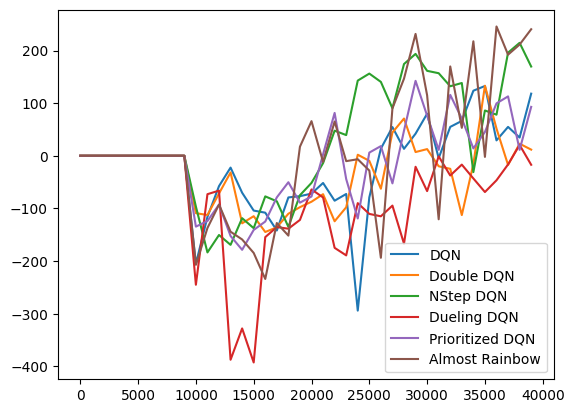

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(results_dqn.shape[0])*1000
plt.plot(x, results_dqn.mean(1), label='DQN')
plt.plot(x, results_dqn1.mean(1), label='Double DQN')
plt.plot(x, results_dqn2.mean(1), label='NStep DQN')
plt.plot(x, results_dqn3.mean(1), label='Dueling DQN')
plt.plot(x, results_dqn4.mean(1), label='Prioritized DQN')
plt.plot(x, results_dqn5.mean(1), label='Almost Rainbow')
plt.legend(loc="lower right")
plt.show()

<ipython-input-25-56d43f6e0c2d>:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


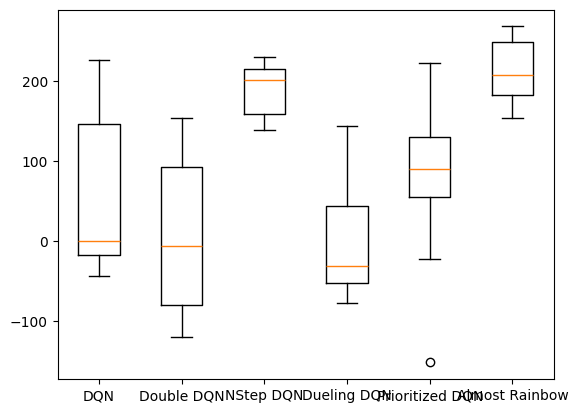

In [ ]:
plt.boxplot(
    labels=["DQN", "Double DQN", "NStep DQN", "Dueling DQN", "Prioritized DQN", "Almost Rainbow"],
    x=[
        results_dqn[-3:].flatten(),
        results_dqn1[-3:].flatten(),
        results_dqn2[-3:].flatten(),
        results_dqn3[-3:].flatten(),
        results_dqn4[-3:].flatten(),
        results_dqn5[-3:].flatten(),
    ],
)
plt.show()

### 5.5. Comment results [2pt]:

I re-ran the notebook multiple times and observed large run-to-run variability, so these numbers should be taken with caution:

-  **Double DQN** usually outperforms **vanilla DQN**, but in this run it did not.

- **NStep DQN** consistently the tightest reward distribution across seeds. It also drives one of the fastest early improvements, possible because the multi-step returns propagate the sparse landing bonus more quickly and smooth out per-step noise.

- **Dueling DQN** performed worst, with the lowest median and very noisy outcomes. One of possible reasons is a extra bias from splitting into separate value and advantage streams.

- **Prioritized DQN** achieves the third-highest median but still shows a widespread. Prioritization clearly accelerates learning, though it may introduce extra variance. Especially early on, as the loss is multiplied by importance sampling weights, which downscale large errors and can slow learning when the initial policy is poor.

- **(Almost) rainbow** has a high median overall and usually performs best together with **Nstep DQN**.

## 6. Run and compare results for different values of a selected parameter [3pts]

Select a paramter of RAINBOW algorithm:
- `nstep` of N-step Q-value,
- `omega` or,
- `initial_beta` and `final_beta` of Prioritized Experience Replay.

Gather results for different values of this parameter (at least 4 different including the default value used above) using AlmostRainbow algorithm. Make sure to include minimal/maximal valid values for this parameter if its valid range is bounded.

Compare and comment the results.

Since the results were unstable, I decided to run tests for each of these parameters.


Training RainbowDQN with nstep=1
Step: 39999 Evaluation reward: 264.00 Samples per second: 151 	 	

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training RainbowDQN with nstep=3
Step: 39999 Evaluation reward: -153.38 Samples per second: 152 	 	

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training RainbowDQN with nstep=5
Step: 39999 Evaluation reward: 268.19 Samples per second: 162 	 	

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training RainbowDQN with nstep=10
Step: 39999 Evaluation reward: 70.24 Samples per second: 171 	 	

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Final Performance by N-Step')

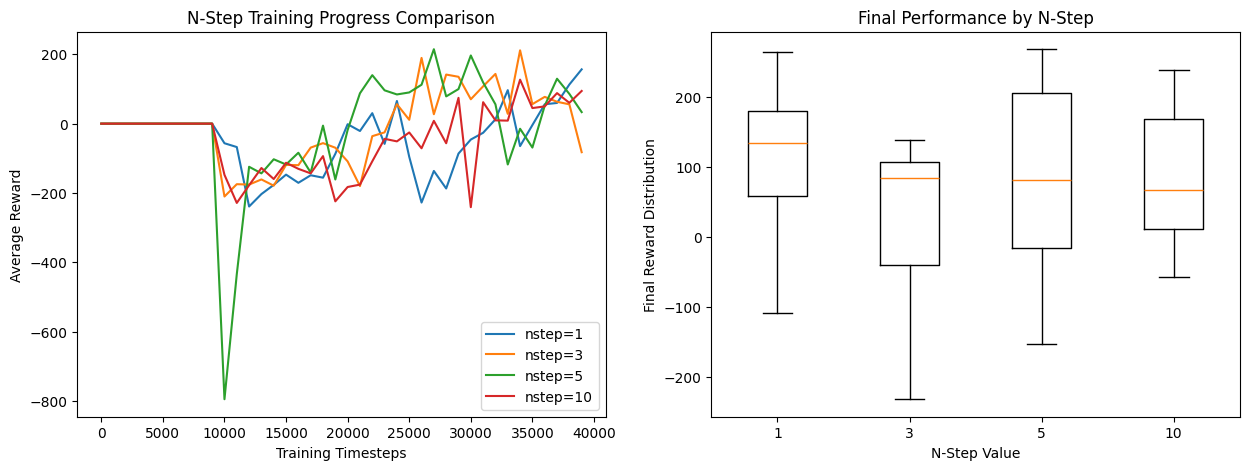

In [ ]:
nstep_values = [1, 3, 5, 10]
results_nstep = {}

for nstep in nstep_values:
    print(f"Training RainbowDQN with nstep={nstep}")
    agent = RainbowDQN(args, nstep=nstep)
    results = train_agent(args, agent)
    results_nstep[nstep] = results
    download_numpy(f"results_nstep_{nstep}.npy", results)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

x = np.arange(results.shape[0])*1000
for nstep, results in results_nstep.items():
    ax1.plot(x, results.mean(1), label=f'nstep={nstep}')
ax1.legend(loc="lower right")
ax1.set_xlabel("Training Timesteps")
ax1.set_ylabel("Average Reward")
ax1.set_title("N-Step Training Progress Comparison")

final_rewards = [results[-3:].flatten() for results in results_nstep.values()]
ax2.boxplot(final_rewards, tick_labels=nstep_values)
ax2.set_xlabel("N-Step Value")
ax2.set_ylabel("Final Reward Distribution")
ax2.set_title("Final Performance by N-Step")

For `nstep=1`, we see high-variance learning throughout: one-step TD updates are too noisy, and I’ve observed cases where it underperforms in the final phase of training.

In this run, `nstep=3` performs poorly at the end, making it look like the worst choice here. However, that’s not usually the case, the training plot shows it outperforming both `nstep=10` and `nstep=1` during the middle phase.

By contrast, `nstep=5` struggles in the early phases, but both `nstep=5` and `nstep=10` recover by the end and yield reasonable policies with much more stable behavior.

Overall, `nstep=3` or `nstep=5` usually strikes the optimal bias–variance trade‐off here: it integrates enough future reward to accelerate learning without compounding too much estimation error.

---

Training RainbowDQN with omega=0
Step: 39999 Evaluation reward: 176.83 Samples per second: 148 	 	

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training RainbowDQN with omega=0.5
Step: 39999 Evaluation reward: 208.58 Samples per second: 153 	 	

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training RainbowDQN with omega=1
Step: 39999 Evaluation reward: 140.35 Samples per second: 161 	 	

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training RainbowDQN with omega=2
Step: 39999 Evaluation reward: -334.63 Samples per second: 174 	 	

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Final Performance by Omega')

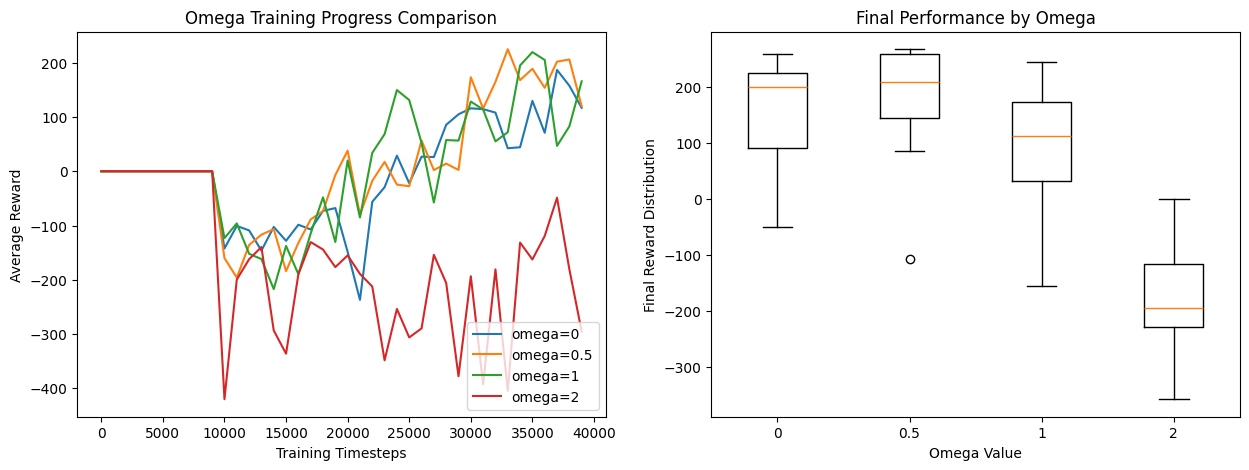

In [ ]:
omega_values = [0, 0.5, 1, 2]
results_omega = {}

for omega in omega_values:
    print(f"Training RainbowDQN with omega={omega}")
    agent = RainbowDQN(args, omega=omega)
    results = train_agent(args, agent)
    results_omega[omega] = results
    download_numpy(f"results_omega_{omega}.npy", results)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

x = np.arange(results.shape[0])*1000
for omega, results in results_omega.items():
    ax1.plot(x, results.mean(1), label=f'omega={omega}')
ax1.legend(loc="lower right")
ax1.set_xlabel("Training Timesteps")
ax1.set_ylabel("Average Reward")
ax1.set_title("Omega Training Progress Comparison")

final_rewards = [results[-3:].flatten() for results in results_omega.values()]
ax2.boxplot(final_rewards, tick_labels=omega_values)
ax2.set_xlabel("Omega Value")
ax2.set_ylabel("Final Reward Distribution")
ax2.set_title("Final Performance by Omega")

For `omega = 0`, all priorities are equal, yielding a solid baseline without extreme failures, but the reward box remains wide, indicating high variance here.

The best performance is for `omega=0.5`, which delivers an evaluation reward of $\approx 208.58$, as it lightly skews sampling toward informative transitions without overemphasizing outliers. For `omega=1` we observe less stability for mid- and late-training.

For `omega = 2` replay focuses too heavily on large TD errors, and even with importance‐sampling correction weights the updates become erratic, leading to lower medians and frequent crashes.

---

Training RainbowDQN with initial_beta=0
Step: 39999 Evaluation reward: 213.53 Samples per second: 158 	 	

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training RainbowDQN with initial_beta=0.4
Step: 39999 Evaluation reward: 242.07 Samples per second: 159 	 	

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training RainbowDQN with initial_beta=0.7
Step: 39999 Evaluation reward: 284.31 Samples per second: 155 	 	

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training RainbowDQN with initial_beta=1.0
Step: 39999 Evaluation reward: 228.34 Samples per second: 156 	 	

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Final Performance by Initial_beta')

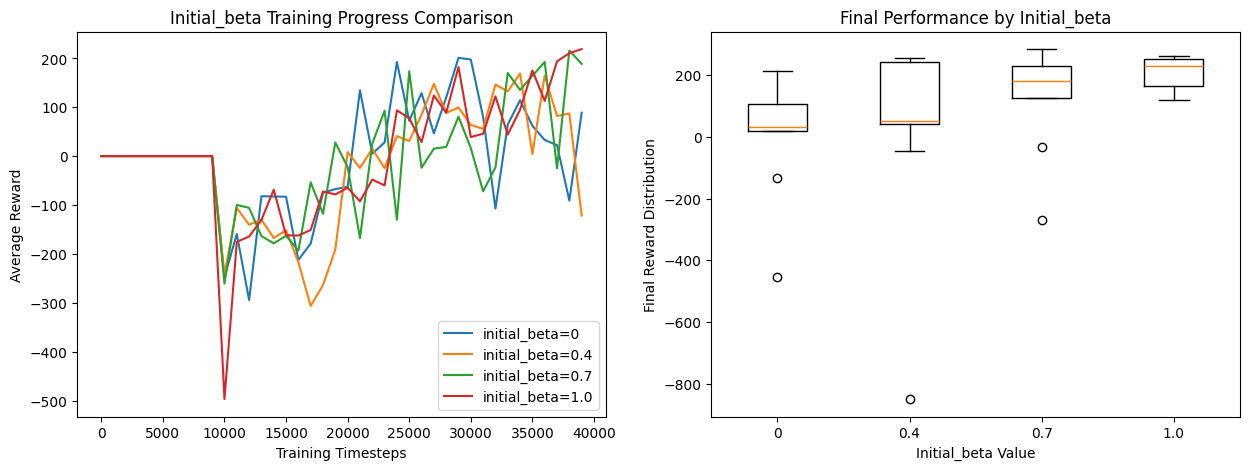

In [ ]:
initial_beta_values = [0, 0.4, 0.7, 1.0]
results_initial_beta = {}

for initial_beta in initial_beta_values:
    print(f"Training RainbowDQN with initial_beta={initial_beta}")
    agent = RainbowDQN(args, initial_beta=initial_beta, final_beta=1)
    results = train_agent(args, agent)
    results_initial_beta[initial_beta] = results
    download_numpy(f"results_initial_beta_{initial_beta}.npy", results)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

x = np.arange(results.shape[0])*1000
for initial_beta, results in results_initial_beta.items():
    ax1.plot(x, results.mean(1), label=f'initial_beta={initial_beta}')
ax1.legend(loc="lower right")
ax1.set_xlabel("Training Timesteps")
ax1.set_ylabel("Average Reward")
ax1.set_title("Initial_beta Training Progress Comparison")

final_rewards = [results[-3:].flatten() for results in results_initial_beta.values()]
ax2.boxplot(final_rewards, tick_labels=initial_beta_values)
ax2.set_xlabel("Initial_beta Value")
ax2.set_ylabel("Final Reward Distribution")
ax2.set_title("Final Performance by Initial_beta")

For `initial_beta=0`, `initial_beta=0.4`, and `initial_beta=0.7`, learning ramps up fastest in the early phase, their mid- and late-training curves remain jittery, and their final reward boxes are wider. In contrast, `initial_beta=1.0` learns more slowly at first (uniform replay) but then settles: from $\approx 20 000$ steps onward it exhibits the least volatility and finishes with the tightest interquartile range and highest median. However, all four settings produce overlapping distributions, and run-to-run noise is large, so it’s hard to say which choice is truly superior.

---

Training RainbowDQN with final_beta=0
Step: 39999 Evaluation reward: 154.60 Samples per second: 168 	 	

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training RainbowDQN with final_beta=0.4
Step: 39999 Evaluation reward: 177.91 Samples per second: 159 	 	

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training RainbowDQN with final_beta=1.0
Step: 39999 Evaluation reward: 164.63 Samples per second: 157 	 	

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training RainbowDQN with final_beta=1.5
Step: 39999 Evaluation reward: 29.14 Samples per second: 174 	 	

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Final Performance by final_beta')

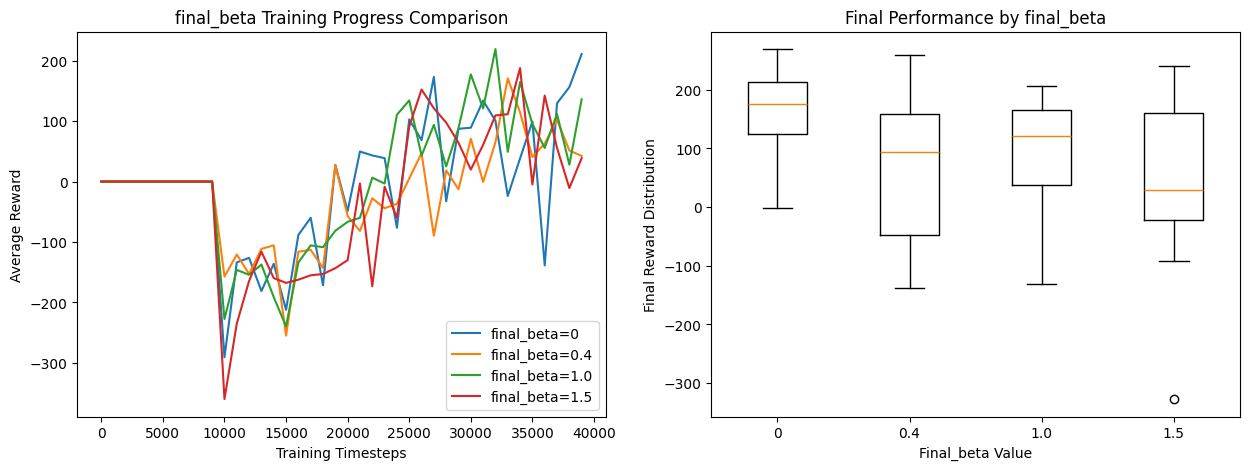

In [ ]:
final_beta_values = [0, 0.4, 1.0, 1.5]
results_final_beta = {}

for final_beta in final_beta_values:
    print(f"Training RainbowDQN with final_beta={final_beta}")
    agent = RainbowDQN(args, initial_beta=0.4, final_beta=final_beta)
    results = train_agent(args, agent)
    results_final_beta[final_beta] = results
    download_numpy(f"results_final_beta_{final_beta}.npy", results)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

x = np.arange(results.shape[0])*1000
for final_beta, results in results_final_beta.items():
    ax1.plot(x, results.mean(1), label=f'final_beta={final_beta}')
ax1.legend(loc="lower right")
ax1.set_xlabel("Training Timesteps")
ax1.set_ylabel("Average Reward")
ax1.set_title("final_beta Training Progress Comparison")

final_rewards = [results[-3:].flatten() for results in results_final_beta.values()]
ax2.boxplot(final_rewards, tick_labels=final_beta_values)
ax2.set_xlabel("Final_beta Value")
ax2.set_ylabel("Final Reward Distribution")
ax2.set_title("Final Performance by final_beta")

For `final_beta = 0.0` and `final_beta = 0.4`, both settings show similarly chaotic behavior in the mid-to-late phase ($\approx 25 000–35 000$ steps): importance‐sampling correction fades out or never fully kicks in, so late‐training bias persists and the learning curves oscillate heavily, yet they still yield among the highest median rewards.

By contrast, `final_beta = 1.0` and `final_beta = 1.5`,ramp up to full correction late in training—which in theory should reduce bias once the agent has mostly learned. And indeed they show somewhat less chaotic oscillations around $25 000–35 000$ steps than the `0.0` / `0.4` settings. However, they still exhibit large jumps in performance and extreme variance.

These results seem full of noise due to the instability during training, and in a previous run I saw the best performance at `final_beta = 0.4`. However, since the medians for these settings are so close, it’s hard to tell genuine improvements from random fluctuations.